# CNN layers and feature visualization

In [6]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import model_training as mt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load FMNIST

In [7]:
transform = transforms.ToTensor()

trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

## Define a CNN

In [21]:
class Net(nn.Module):
    def __init__(self, n_classes):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.fc1 = nn.Linear(20*5*5, 50)
        self.fc1_dropout = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(50, n_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1_dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [22]:
n_classes = 10
net = Net(n_classes)
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (fc1_dropout): Dropout(p=0.4)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [23]:
test_img = np.random.rand(10, 1, 28, 28).astype("float32")
test_img = (
    (test_img - test_img.min()) 
    / (test_img.max() - test_img.min()))

In [24]:
net(torch.from_numpy(test_img)).shape

torch.Size([10, 10])

## Train CNN

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

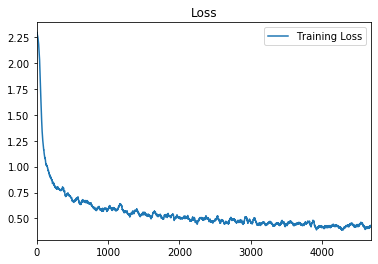

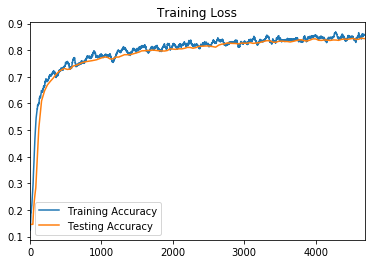

Training loss: 0.4261460818350315
Training Accuracy: 0.85859375
Testing Accuracy: 0.843423730134964
CPU times: user 9min 50s, sys: 5.48 s, total: 9min 56s
Wall time: 6min 30s


In [37]:
%%time
mt.train_model(net, criterion, optimizer, trainloader, testloader, epochs=5)

In [40]:
print(f"Train accuracy: {mt.evaluate_metric_on_dataset(net, trainloader, mt.eval_accuracy)}")
print(f"Test accuracy: {mt.evaluate_metric_on_dataset(net, testloader, mt.eval_accuracy)}")

Train accuracy: 0.8528333306312561
Test accuracy: 0.84579998254776


## Visualize layers

In [63]:
def plot_activation_maps_on_original_image(image, weights):
    plt.imshow(test_image, cmap='gray')

    fig=plt.figure(figsize=(30, 10))
    columns = 5*2
    
    channels = weights.shape[0]
    rows = int(np.ceil(channels / 5))
    for i in range(0, columns*rows):
        fig.add_subplot(rows, columns, i+1)
        if ((i%2)==0):
            plt.imshow(weights[int(i/2)][0], cmap='gray')
        else:
            c = cv2.filter2D(test_image, -1, weights[int((i-1)/2)][0])
            plt.imshow(c, cmap='gray')
    plt.show()

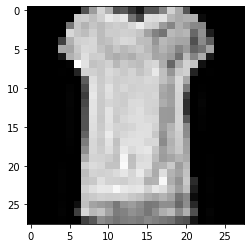

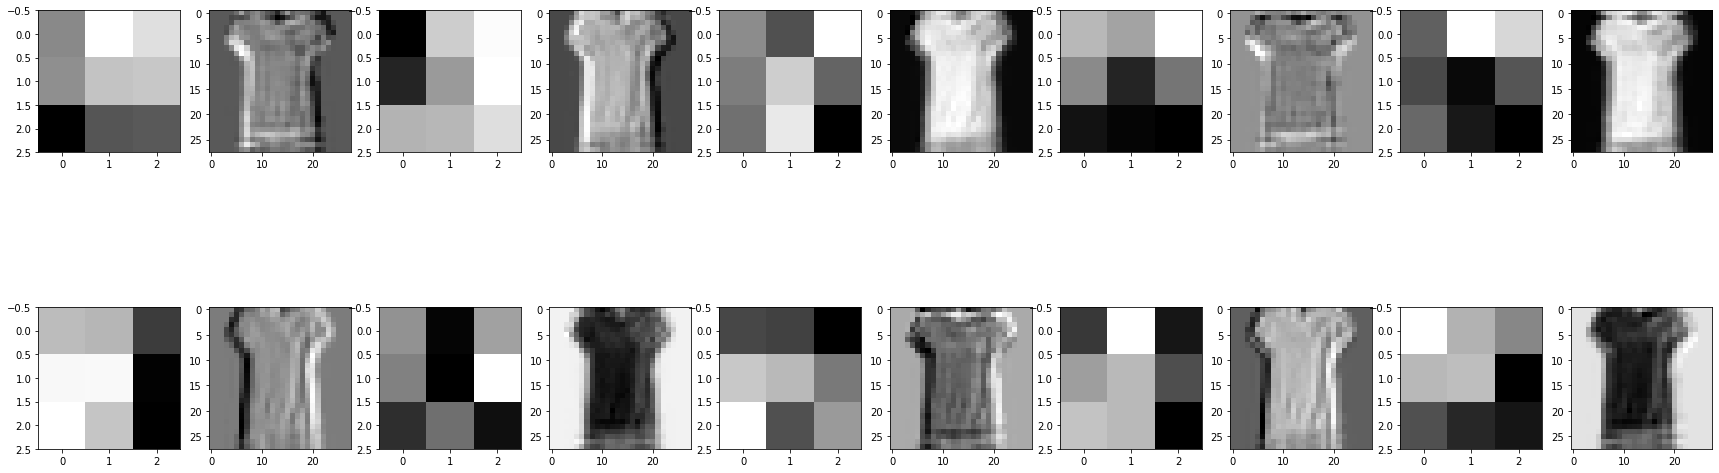

In [64]:
images, _ = iter(testloader).next()
test_image = np.squeeze(images.numpy()[0])

plot_activation_maps_on_original_image(test_image, net.conv1.weight.data.numpy())

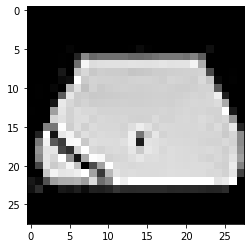

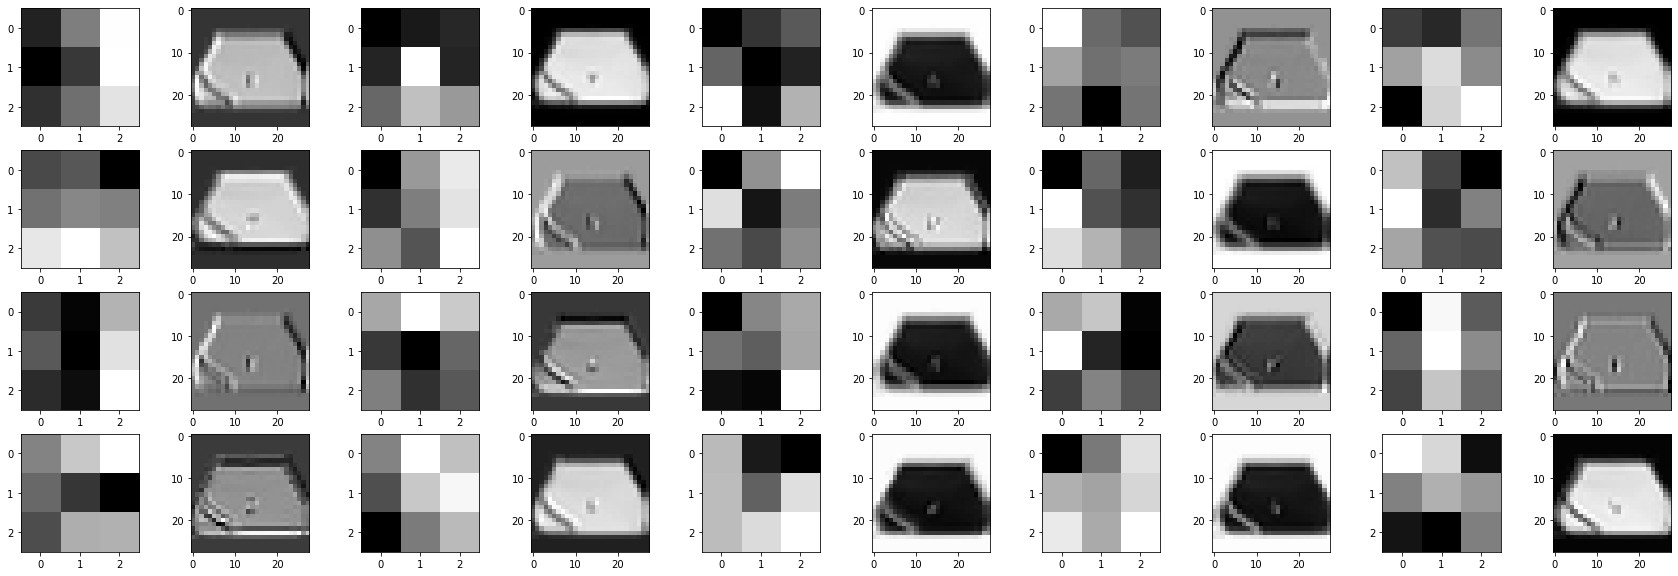

In [65]:
images, _ = iter(testloader).next()
test_image = np.squeeze(images.numpy()[0])

plot_activation_maps_on_original_image(test_image, net.conv2.weight.data.numpy())